In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('max_colwidth', 100)

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
display(df_train.head(),df_test.head())

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


Check for NaN

In [4]:
display(df_train.info(),df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


None

None

In [5]:
# Check for spaces and empty fields in text column
pd.concat([df_train[df_train['text'].str.isspace()],
          df_test[df_test['text'].str.isspace()],
          df_train[df_train['text'].apply(lambda text: text=='')],
           df_test[df_test['text'].apply(lambda text: text=='')]])

,id,keyword,location,text,target


EDA

In [6]:
print(df_train[df_train['target']==1].sample()['text'])
print(df_train[df_train['target']==0].sample()['text'])

3248    He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madin...
Name: text, dtype: object
6822    Hollywood movie about trapped miners released in #Chile http://t.co/r18aUtnLSd #ZippedNews http:...
Name: text, dtype: object


<AxesSubplot:xlabel='target', ylabel='count'>

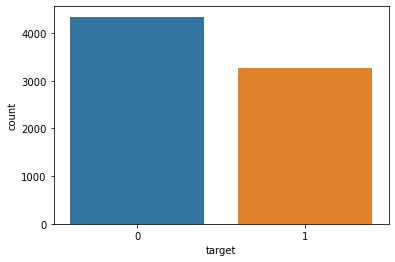

In [7]:
sns.countplot(x=df_train['target'])

In [8]:
def get_missing_data_percentages(df):
    missing_percents = []
    index = []
    
    for column in df.columns:
        percentage = (df[column].isnull().sum()*100/len(df[column]))
        
        if percentage > 0:
            missing_percents.append(percentage)
            index.append(column)
        
    return pd.Series(data=missing_percents,index=index).sort_values(ascending=False)

In [9]:
get_missing_data_percentages(df_train)

location    33.272035
keyword      0.801261
dtype: float64

In [10]:
sns.set(font_scale=1)

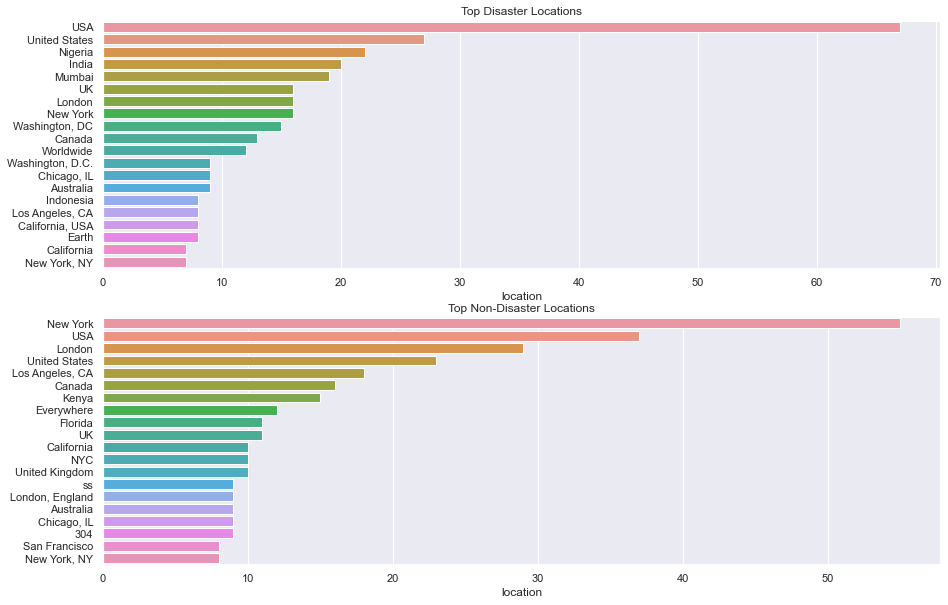

In [11]:
fig, axs = plt.subplots(2,figsize=(15, 10))
sns.barplot(y=df_train[df_train['target']==1]['location'].value_counts().nlargest(20).index,
            x=df_train[df_train['target']==1]['location'].value_counts().nlargest(20),ax=axs[0]);
axs[0].set_title('Top Disaster Locations')
sns.barplot(y=df_train[df_train['target']==0]['location'].value_counts().nlargest(20).index,
            x=df_train[df_train['target']==0]['location'].value_counts().nlargest(20),ax=axs[1]);
axs[1].set_title('Top Non-Disaster Locations');

In [12]:
set(df_test['keyword']) == set(df_train['keyword'])

True

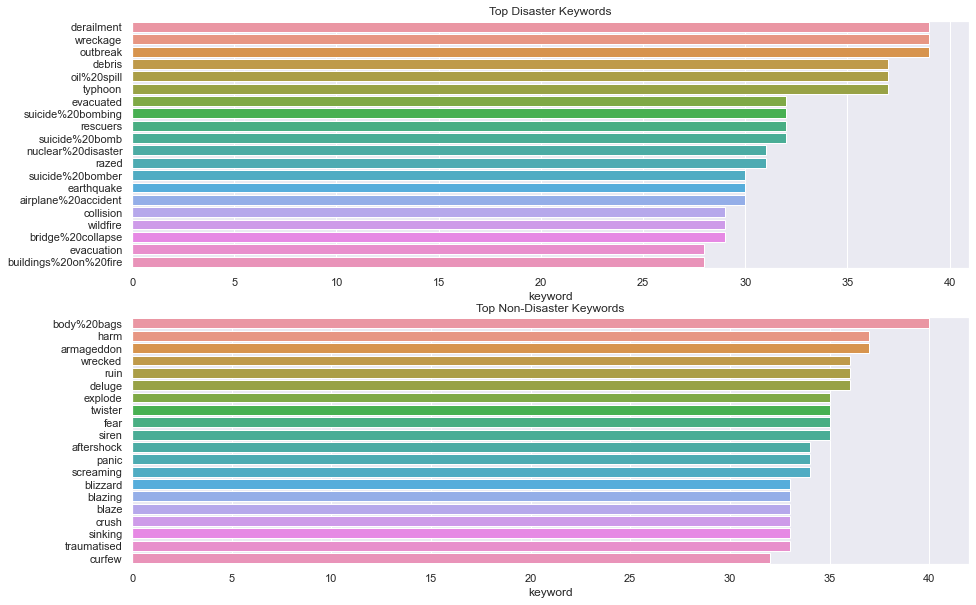

In [13]:
fig, axs = plt.subplots(2,figsize=(15, 10))
sns.barplot(y=df_train[df_train['target']==1]['keyword'].value_counts().nlargest(20).index,
            x=df_train[df_train['target']==1]['keyword'].value_counts().nlargest(20),ax=axs[0]);
axs[0].set_title('Top Disaster Keywords')
sns.barplot(y=df_train[df_train['target']==0]['keyword'].value_counts().nlargest(20).index,
            x=df_train[df_train['target']==0]['keyword'].value_counts().nlargest(20),ax=axs[1]);
axs[1].set_title('Top Non-Disaster Keywords');

In [14]:
print(df_train[(df_train['target']==0) & (df_train['keyword']=='body%20bags')]['text'].sample())
print(df_train[(df_train['target']==0) & (df_train['keyword']=='explode')]['text'].sample())

1023    Ain't no bags in the trunk it's a body
Name: text, dtype: object
3423    My brains going to explode i need to leave this house. Ill be out smoking packs if you need me
Name: text, dtype: object


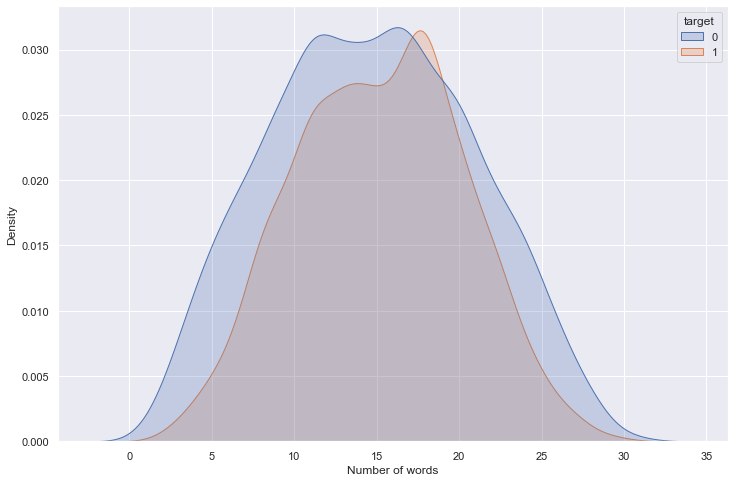

In [15]:
word_length=[]
for i in df_train['text']:
    word_length.append(len(i.split()))
    
plt.figure(figsize=(12,8))
sns.kdeplot(word_length,hue=df_train['target'],fill=True);
plt.xlabel('Number of words');

Cleaning text

In [16]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import WordNetLemmatizer
import re

In [17]:
df = pd.concat([df_train,df_test],ignore_index=True)

In [18]:
def clean_text_one(text):
    
    text=text.lower()
    text=re.sub(r'http?s?://\S+|www\.\S+','',text) # remove web addresses
    text=re.sub('[^a-zA-Z]',' ',text) # removes non-alphabetical characters within strings
    
    return text

In [19]:
df['text'] = df['text'].apply(lambda text: clean_text_one(text))

In [20]:
df['text']

0                                      our deeds are the reason of this  earthquake may allah forgive us all
1                                                                     forest fire near la ronge sask  canada
2        all residents asked to  shelter in place  are being notified by officers  no other evacuation or...
3                                                 people receive  wildfires evacuation orders in california 
4                   just got sent this photo from ruby  alaska as smoke from  wildfires pours into a school 
                                                        ...                                                 
10871                                                earthquake safety los angeles     safety fasteners xrwn
10872    storm in ri worse than last hurricane  my city amp  others hardest hit  my yard looks like it wa...
10873                                                                      green line derailment in chicago 
10874              

In [21]:
lemma = WordNetLemmatizer()

In [22]:
def clean_text_two(text):
    text = re.sub(r'\b\w{1,2}\b', '', str(text)) # matches with words which have two or less characters
    text = re.sub(r' amp ', '',text) # matches with ampersands
    #text=re.sub(r'<.*?>','',text) # matches anything within < >
    #text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text) # remove punctuation
    #text=text.split
    #text=[lemma.lemmatize(word) for word in text if not word in stopwords.words('english')]
    text = re.sub(' +', ' ', text) # matches with white space
    return text    

In [23]:
df['text'] = df['text'].apply(lambda text: clean_text_two(text))

In [24]:
df['text']

0                                             our deeds are the reason this earthquake may allah forgive all
1                                                                         forest fire near ronge sask canada
2        all residents asked shelter place are being notified officers other evacuation shelter place ord...
3                                                     people receive wildfires evacuation orders california 
4                          just got sent this photo from ruby alaska smoke from wildfires pours into school 
                                                        ...                                                 
10871                                                    earthquake safety los angeles safety fasteners xrwn
10872    storm worse than last hurricane city others hardest hit yard looks like was bombed around still ...
10873                                                                         green line derailment chicago 
10874              

More EDA (frequency with wordclouds)

In [25]:
df_train = df.iloc[:7613]
df_test = df.iloc[7613:]

In [26]:
def most_frequent_words(data=df_train,target=1,n=15,n_grams=1):
        
    vec = CountVectorizer(ngram_range=(n_grams, n_grams), stop_words='english').fit(df_train[df_train['target'] == target]['text'])
    bag_of_words = vec.transform(df_train[df_train['target'] == target]['text'])

    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

    top_words={}
    for word, freq in words_freq[:n]:
        top_words[word] = freq
        
    return top_words

In [27]:
display('Disaster Unigrams',most_frequent_words(target=1,n_grams=1),
        'Non-Disaster Unigrams',most_frequent_words(target=0,n_grams=1))

'Disaster Unigrams'

{'news': 151,
 'disaster': 121,
 'california': 115,
 'suicide': 112,
 'police': 109,
 'people': 105,
 'killed': 95,
 'like': 94,
 'hiroshima': 94,
 'just': 89,
 'storm': 89,
 'fires': 86,
 'crash': 85,
 'families': 81,
 'train': 79}

'Non-Disaster Unigrams'

{'like': 254,
 'just': 234,
 'new': 171,
 'don': 140,
 'body': 116,
 'video': 96,
 'people': 95,
 'love': 91,
 'time': 88,
 'day': 86,
 'know': 86,
 'got': 85,
 'emergency': 81,
 'going': 76,
 'youtube': 76}

In [28]:
display('Disaster Bigrams',most_frequent_words(target=1,n_grams=2),
        'Non-Disaster Bigrams',most_frequent_words(target=0,n_grams=2))

'Disaster Bigrams'

{'suicide bomber': 59,
 'northern california': 41,
 'oil spill': 38,
 'burning buildings': 37,
 'suicide bombing': 35,
 'california wildfire': 34,
 'bomber detonated': 30,
 'homes razed': 29,
 'year old': 28,
 'latest homes': 28,
 'razed northern': 28,
 'pkk suicide': 28,
 'detonated bomb': 28,
 'severe thunderstorm': 27,
 'mass murder': 27}

'Non-Disaster Bigrams'

{'cross body': 39,
 'youtube video': 36,
 'liked youtube': 35,
 'body bag': 27,
 'body bagging': 24,
 'burning buildings': 23,
 'body bags': 22,
 'looks like': 21,
 'reddit quarantine': 21,
 'quarantine offensive': 21,
 'feel like': 20,
 'offensive content': 20,
 'content policy': 20,
 'loud bang': 19,
 'pick fan': 17}

Words in disaster tweets generally have a castastrophic theme (e.g. fire, storm, flood, death), whereas non-disaster tweets
generally do not follow this theme (e.g. time, day, love). Some words common to both types of tweet (e.g. people, new, will)

In [29]:
display('Disaster Trigrams',most_frequent_words(target=0,n_grams=3),
        'Non-Disaster Trigrams',most_frequent_words(target=1,n_grams=3))

'Disaster Trigrams'

{'liked youtube video': 35,
 'reddit quarantine offensive': 21,
 'quarantine offensive content': 20,
 'cross body bag': 19,
 'pick fan army': 17,
 'reddit new content': 16,
 'new content policy': 16,
 'china stock market': 16,
 'stock market crash': 16,
 'ignition knock detonation': 15,
 'knock detonation sensor': 15,
 'content policy goes': 15,
 'policy goes effect': 15,
 'goes effect horrible': 15,
 'effect horrible subreddits': 15}

'Non-Disaster Trigrams'

{'suicide bomber detonated': 30,
 'northern california wildfire': 29,
 'latest homes razed': 28,
 'homes razed northern': 28,
 'pkk suicide bomber': 28,
 'bomber detonated bomb': 28,
 'razed northern california': 27,
 'old pkk suicide': 27,
 'families sue legionnaires': 26,
 'families affected fatal': 26,
 'affected fatal outbreak': 26,
 'obama declares disaster': 25,
 'declares disaster typhoon': 25,
 'disaster typhoon devastated': 25,
 'typhoon devastated saipan': 25}

In [30]:
from wordcloud import WordCloud

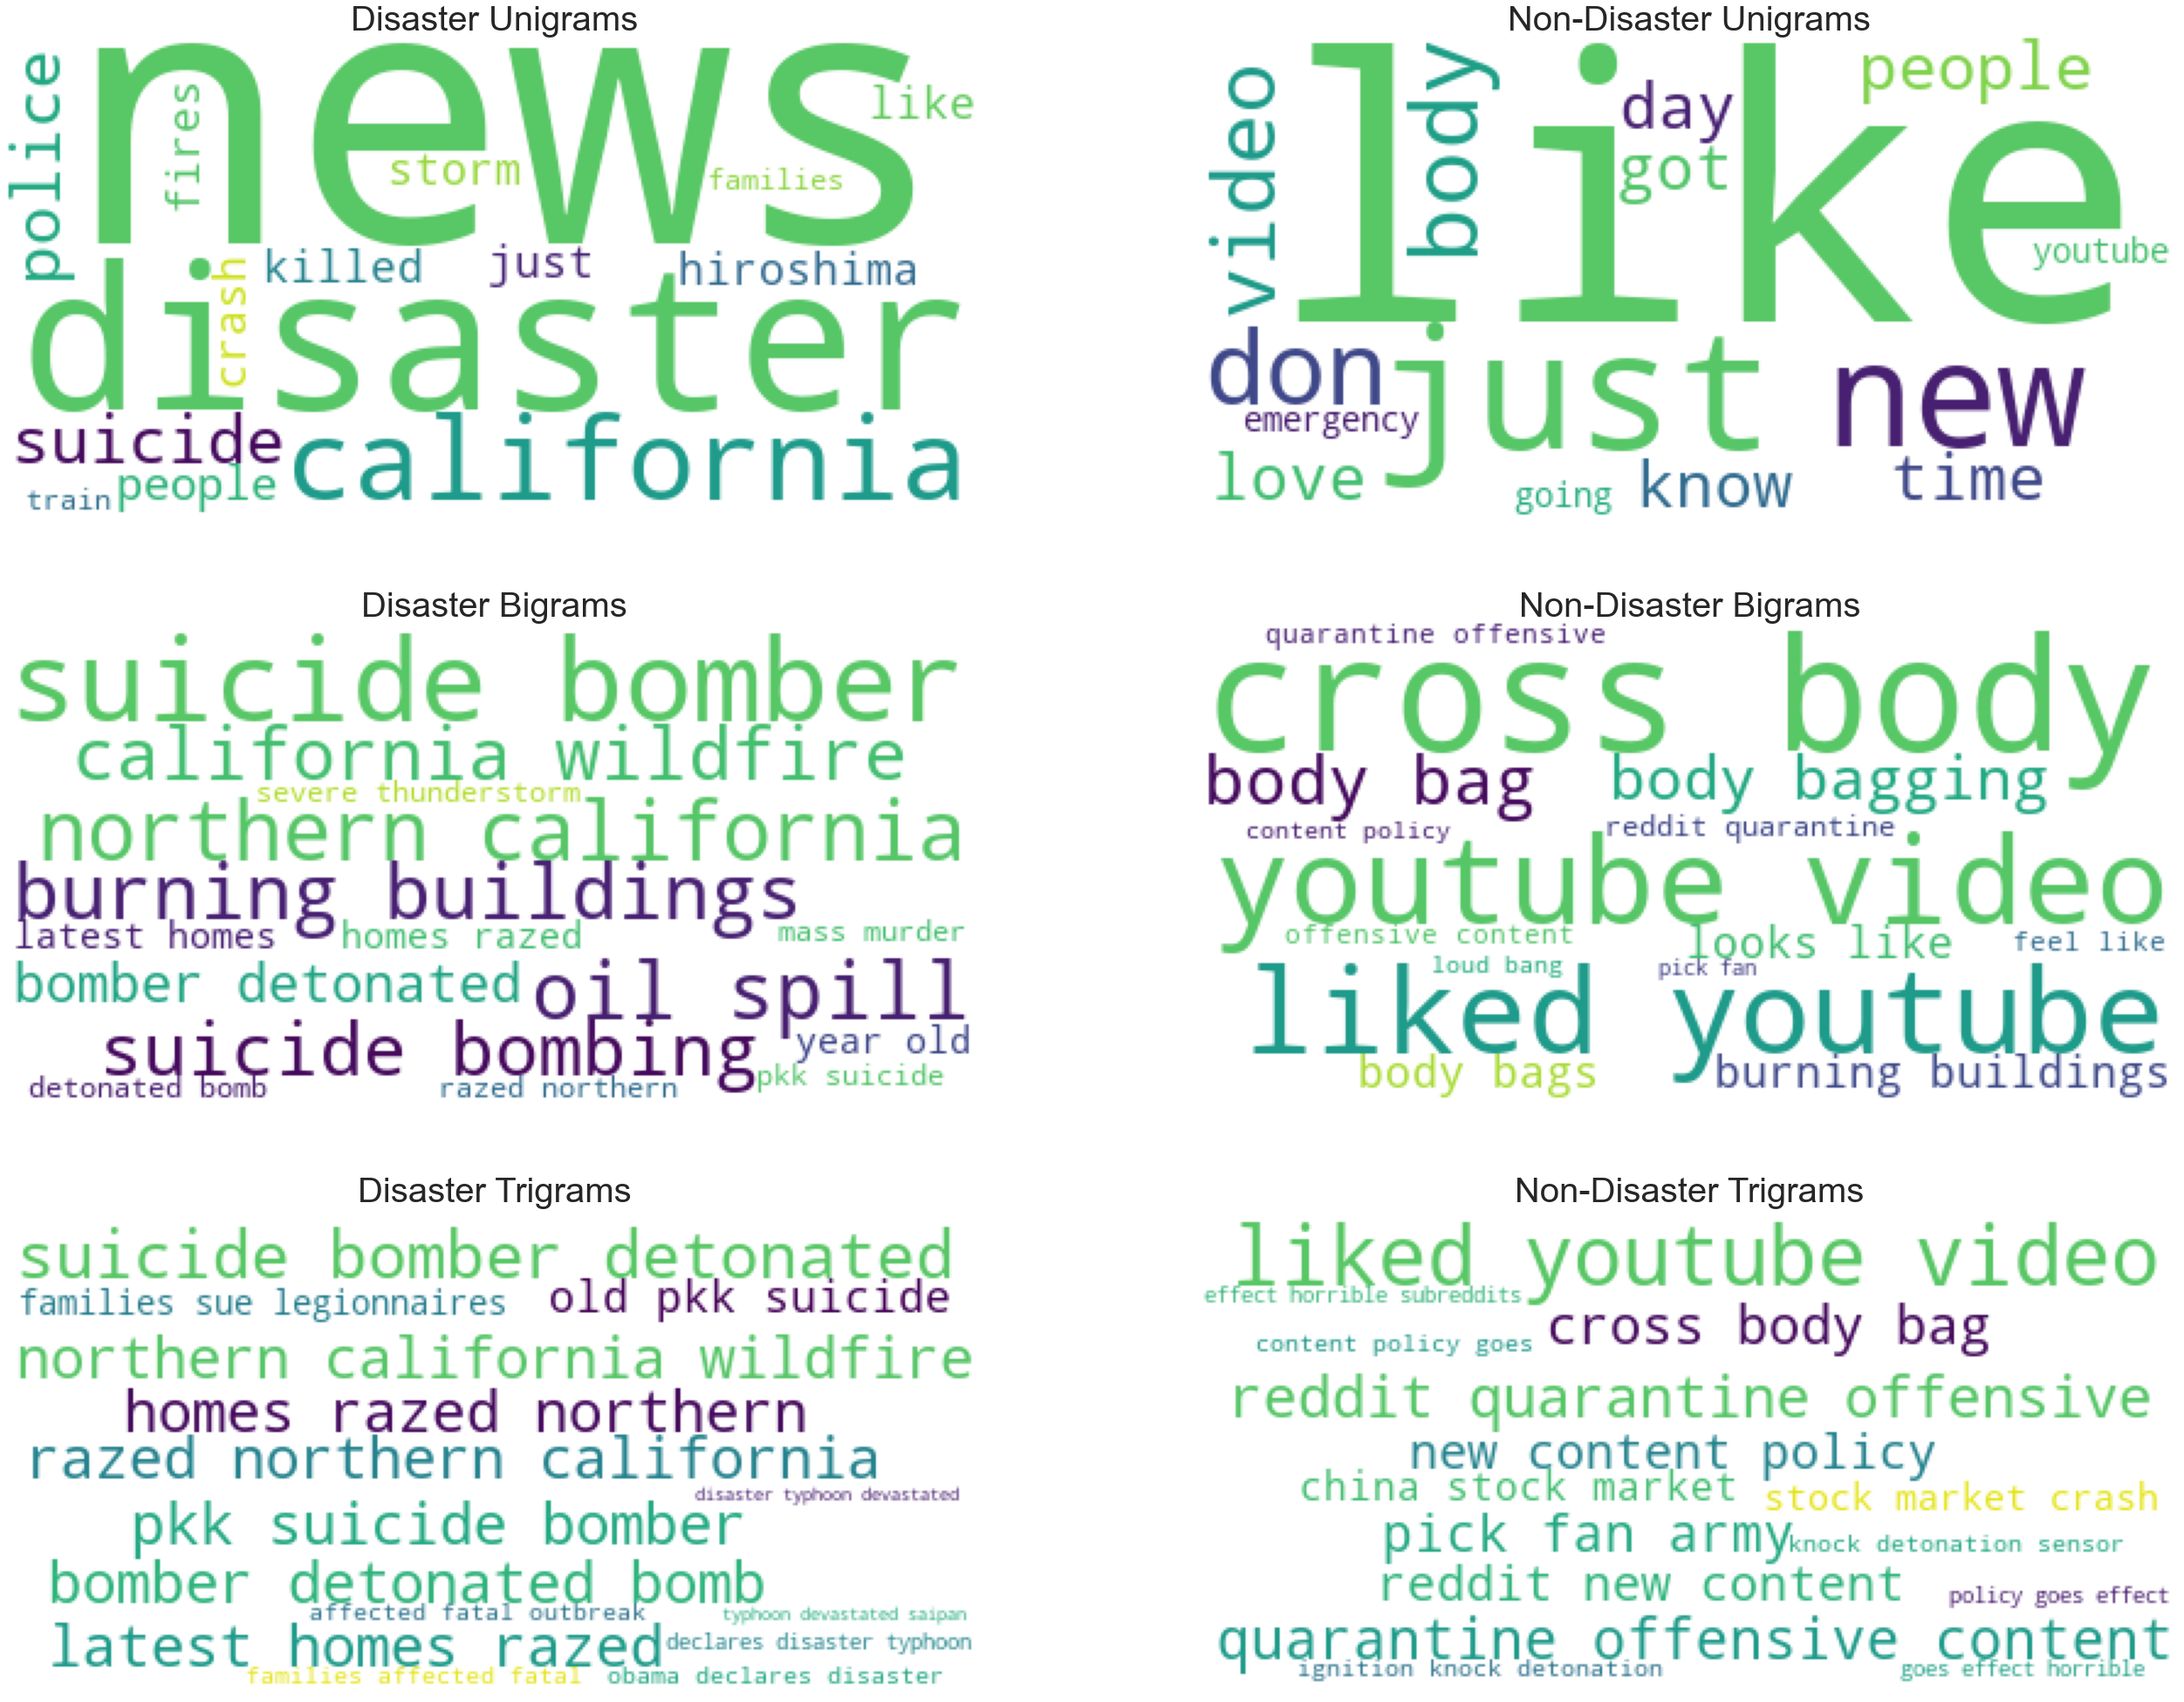

In [31]:
plt.rcParams['figure.figsize'] = [45,35]

titles = ['Disaster Unigrams', 'Non-Disaster Unigrams',
         'Disaster Bigrams', 'Non-Disaster Bigrams',
         'Disaster Trigrams', 'Non-Disaster Trigrams']
targets = [1,0,1,0,1,0]
n_grams = [1,1,2,2,3,3]

for index, (target, n_grams, title) in enumerate(zip(targets,n_grams,titles)):
    wc = WordCloud(background_color='white',max_font_size=150, random_state=42)
    wc.generate_from_frequencies(most_frequent_words(target=target,n_grams=n_grams))
    plt.subplot(3, 2, index+1)
    plt.imshow(wc)
    plt.axis("off")
    plt.title(title,fontsize=40)
plt.show()

Supervised modelling

In [32]:
tfidf = TfidfVectorizer(stop_words = 'english')
X_tfidf = tfidf.fit_transform(df['text'])
X_train_tfidf = X_tfidf[:7613]
X_test_tfidf = X_tfidf[7613:]

In [33]:
y_train = df_train['target']

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
X2_train_tfidf, X2_test_tfidf, y2_train, y2_test = train_test_split(
    X_train_tfidf, y_train, test_size=0.2, random_state=101)

In [36]:
# Try a selection of classification algorithms. Tree methods not suitable for NLP as potential number of splits on different words is large

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC,LinearSVC

nb = MultinomialNB()
log_model = LogisticRegression(max_iter=1000)
rbf_svc = SVC()
linear_svc = LinearSVC()

models = {'Naive-Bayes': nb,'Logistic Regression': log_model,
          'RBF SVC': rbf_svc, 'Linear SVC': linear_svc}

In [37]:
from sklearn.metrics import plot_confusion_matrix,classification_report

In [38]:
def report(model,model_name,X,y):
    preds = model.predict(X)
    print(classification_report(y,preds))
    sns.set(font_scale=2.0)
    fig, ax = plt.subplots(figsize=(6, 6))
    plot_confusion_matrix(model,X,y,ax=ax)
    ax.set_title(model_name)

Naive-Bayes
              precision    recall  f1-score   support

         0.0       0.79      0.89      0.83       892
         1.0       0.80      0.66      0.72       631

    accuracy                           0.79      1523
   macro avg       0.79      0.77      0.78      1523
weighted avg       0.79      0.79      0.79      1523

Logistic Regression
              precision    recall  f1-score   support

         0.0       0.77      0.91      0.84       892
         1.0       0.83      0.62      0.71       631

    accuracy                           0.79      1523
   macro avg       0.80      0.77      0.78      1523
weighted avg       0.80      0.79      0.79      1523

RBF SVC
              precision    recall  f1-score   support

         0.0       0.76      0.93      0.84       892
         1.0       0.85      0.58      0.69       631

    accuracy                           0.79      1523
   macro avg       0.81      0.76      0.77      1523
weighted avg       0.80      0.79 

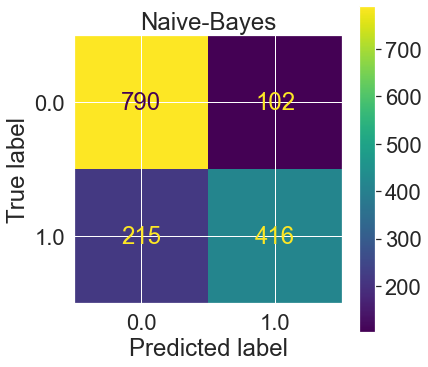

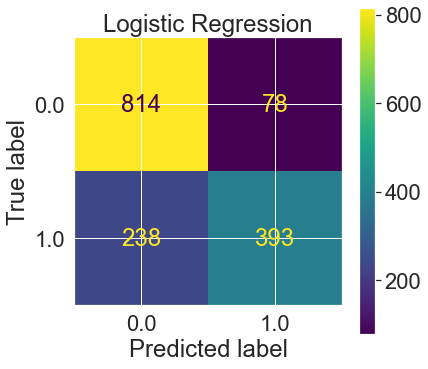

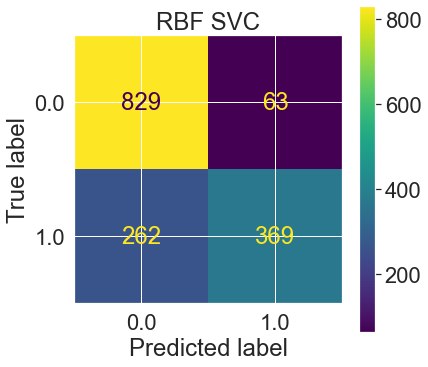

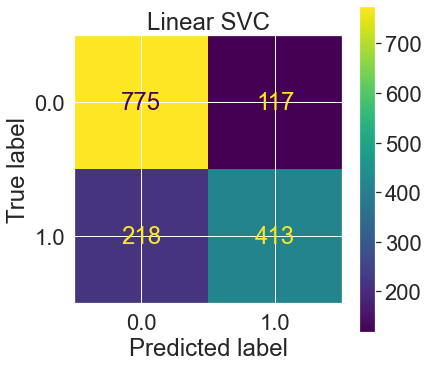

In [39]:
for model_name, model in models.items():
    print(model_name)
    model.fit(X2_train_tfidf,y2_train)
    report(model,model_name,X2_test_tfidf,y2_test)

In [40]:
# Grid search to optimise hyper-parameters for SVC and Logistic regression

from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV

Logistic Regression
              precision    recall  f1-score   support

         0.0       0.78      0.88      0.83       892
         1.0       0.80      0.66      0.72       631

    accuracy                           0.79      1523
   macro avg       0.79      0.77      0.78      1523
weighted avg       0.79      0.79      0.79      1523

RBF SVC
              precision    recall  f1-score   support

         0.0       0.80      0.88      0.84       892
         1.0       0.80      0.69      0.74       631

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.80      1523



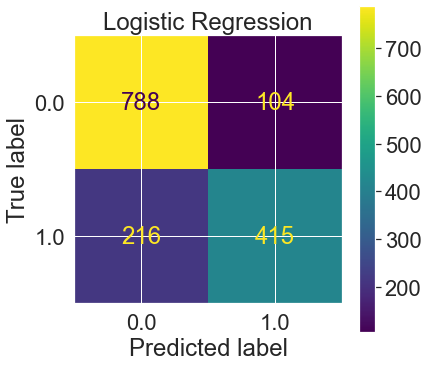

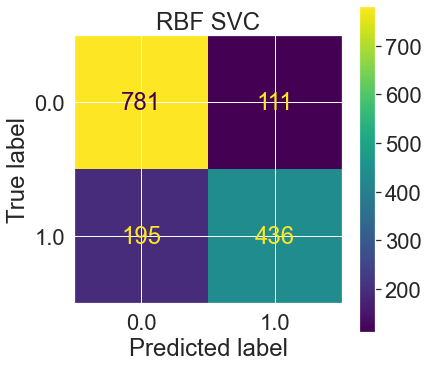

In [44]:
log_model = LogisticRegressionCV(max_iter=10000,Cs=10)

svc = SVC(class_weight='balanced', kernel='linear')
param_grid = {'C':[0.001,0.01,0.1,0.5,1]}
grid = GridSearchCV(svc,param_grid)

models = {'Logistic Regression': log_model,'RBF SVC': grid}

for model_name, model in models.items():
    print(model_name)
    model.fit(X2_train_tfidf,y2_train)
    report(model,model_name,X2_test_tfidf,y2_test)

In [49]:
log_model.fit(X_train_tfidf,y_train)
preds = log_model.predict(X_test_tfidf)
submission = pd.read_csv('sample_submission.csv')
submission['target'] = preds.astype(int)
submission.to_csv('log_model_attempt.csv',index=False)

LogisticRegressionCV(max_iter=10000)

In [45]:
log_model = LogisticRegressionCV(max_iter=10000,Cs=10)

svc = SVC(class_weight='balanced', kernel='linear')
param_grid = {'C':[0.001,0.01,0.1,0.5,1]}
grid = GridSearchCV(svc,param_grid)

models = {'Logistic Regression': log_model,'RBF SVC': grid}

sub_number = 0

for model_name, model in models.items():
    print(model_name)
    model.fit(X_train_tfidf,y_train)
    preds = model.predict(X_test_tfidf)
    submission = pd.read_csv('sample_submission.csv')
    submission['target'] = preds.astype(int)
    submission.to_csv(f'{model_name}_{sub_number}.csv',index=False)
    sub_number += 1

Logistic Regression
RBF SVC


In [51]:
grid.fit(X_train_tfidf,y_train)
preds = grid.predict(X_test_tfidf)
submission = pd.read_csv('sample_submission.csv')
submission['target'] = preds.astype(int)
submission.to_csv('SVC_attempt.csv',index=False)

GridSearchCV(estimator=SVC(class_weight='balanced', kernel='linear'),
             param_grid={'C': [0.001, 0.01, 0.1, 0.5, 1]})